# Imports

In [1]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go 
import gudhi as gd
import matplotlib.pyplot as plt

# Load Data if Doing a Dataset

In [2]:
l63 = np.load("Data/Lorenz63/lorenz_10k_raw.npy").T[:,10000:100000] #3x1250000, so dimensionality is fine, but need to pare down length
l96 = np.loadtxt("Data/Lorenz96/lorenz96_raw.txt")#[:3,10000:90000] #8x100000, length is probably fine, but need to use only first three dimensions for visualization purposes 
cdv = np.fromfile("Data/CDV/cdv_deterministic.npy").reshape(6,-1)#[:3,10000:90000] #6x2000000, use first three dimensions and cut down on length a lot
jetlat = np.loadtxt("Data/JetLat/JetLat.txt", delimiter = ",").T #3x9809 this one is either already reduced by Kristian et al or just fine as is

# Functions

In [3]:
#Inputs: ts - a 2D np array of any shape. Probably a time series. 
# b - the number of bins in each dimension
#Output: bins - A dictionary of arrays that contains the boundaries of the bins in each dimension

def get_bins(ts,b):
    d,n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i,:])
        bot = min(ts[i,:])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins

In [4]:
#Inputs: ts - time series
#bins - the partition of each dimension into its bins
#b - number of bins in each dimension

#Output: binseq - a 1D array the length of ts that lists which bin each entry in the time series is in

def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [5]:
#inputs: bin-seq - the bin sequence of the time series
#outputs: A - the adjacency matrix
# vertices - the list of vertices, enumerated as bin number

def adjacency(bin_seq, prob = False):
    vertices, counts = np.unique(bin_seq, return_counts=True)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    if prob:
        A[:,i] = A[:,i]/np.sum(A[:,i])
    return A, vertices, counts

In [6]:
# inputs: A - the adjacency matrix
# vertices - the list of vertices, which are the bin numbers
# loops - whether or not to keep the self-loops in the graph, I am going to do something with this eventually when I include some sort of markovian random walk diffusion distance 
#Output: G - a networkx digraph

def digraph(A, vertices, counts, loops: bool):
    if loops == False:
        np.fill_diagonal(A,0)
        G = nx.DiGraph(A)
    elif loops == True:
        G = nx.DiGraph(A)
    for i in range(len(G.nodes)):
       G.nodes[i]['bin'] = vertices[i]
       G.nodes[i]['count'] = counts[i]

    return G

In [7]:
def bin_centers(bins, b):
    bin_cent = np.zeros((b**3,3))
    for k in range(b):
        for j in range(b):
            for i in range(b):
                bin_cent[k*b**2 + j*b + i,0] += np.mean(bins[0][i:i+2]) 
                bin_cent[k*b**2 + j*b + i,1] += np.mean(bins[1][j:j+2]) 
                bin_cent[k*b**2 + j*b + i,2] += np.mean(bins[2][k:k+2]) 

    return bin_cent

In [8]:
def graph_graph(G, bin_cents, perc = 0, arrows = False, color_verts = False): 

    fig = go.Figure()

    points_x = []
    points_y = []
    points_z = []

    for node in list(G.nodes):
        points_x.append(bin_cents[int(G.nodes[node]['bin']),0])
        points_y.append(bin_cents[int(G.nodes[node]['bin']),1])
        points_z.append(bin_cents[int(G.nodes[node]['bin']),2])

    fig.add_trace(go.Scatter3d(x=points_x, y=points_y,z=points_z, mode='markers',marker=dict(size=2, color='black',line=dict(width=1, color='white')),showlegend=False))


    if arrows:
        for edge in list(G.edges):
            source = edge[0]
            target = edge[1]
            bin_source = int(G.nodes[source]['bin'])
            bin_target = int(G.nodes[target]['bin'])

            start_x = bin_cents[bin_source,0]
            start_y = bin_cents[bin_source,1]
            start_z = bin_cents[bin_source,2]

            end_x = bin_cents[bin_target,0]
            end_y = bin_cents[bin_target,1]
            end_z = bin_cents[bin_target,2]


            fig.add_trace(go.Scatter3d(x = [start_x,end_x], y = [start_y,end_y], z = [start_z,end_z], marker = dict(size = 3, color = 'black'), showlegend = False))

            dx = end_x - start_x
            dy = end_y - start_y
            dz = end_z - start_z

            fig.add_trace(go.Cone(x = [end_x], y = [end_y], z = [end_z], u = [dx], v = [dy], w = [dz], anchor = 'tip', sizeref = .3, colorscale = [[0,'black'],[1,'black']], showlegend=False, showscale = False))
        
    if color_verts:

        node_x = []
        node_y = []
        node_z = []
        counts = [G.nodes[node]['count'] for node in G.nodes]
        perc = np.percentile(counts, 100-perc)
        dense_points = np.where(counts >= perc)[0]

        for i in dense_points:
            node_x.append(bin_cents[int(G.nodes[i]['bin']),0])
            node_y.append(bin_cents[int(G.nodes[i]['bin']),1])
            node_z.append(bin_cents[int(G.nodes[i]['bin']),2])

        fig.add_trace(go.Scatter3d(x=node_x, y=node_y,z=node_z, mode='markers',marker=dict(size=2, colorscale='Brwnyl',
        colorbar=dict(title="Counts"),line=dict(width=1, color='white')),showlegend=False))

    fig.update_layout(scene=dict(aspectmode='cube'))
    fig.update(layout_showlegend=False)
        
    return fig


In [9]:
#Inputs: G - a networkx graph
# method - the way you want to measure distance on the graph
# Outputs: D - a distance matrix

def distance_matrix(G, method = 'unweighted_shortest_path'):
    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'probabilistic': #since I doubt we are doing this in this paper, I haven't checked exactly if this is right
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    if method == 'weighted_shortest_path':
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

In [10]:
# This cell is copy-pasted from pyDowker
# by Niklas Hellmer and Jan Spalinski, but only the portion
# that's relevant to our project.
# See https://github.com/nihell/pyDowker


from gudhi import SimplexTree
import numpy as np

class DowkerComplex:
    """
    Class MNeighborComplex. Constructs Dowker's simplicial complex for a relation.
    Filtrations can be added using filtered relations, or total weight, or combining both into a bifiltration.
    """

    def __init__(self, rel_matrix, max_filtration=float('inf')) -> None:
        """_summary_
        Constructor for the filtered Dowker complex from the relations given by sublevels of the matrix rel_matrix.
        The vertices in the complex will correspond to the rows of the matrix.
        
        Parameters
        ----------
        rel_matrix (Sequence[Sequence[float]]): distance matrix (full square or lower triangular).
        max_filtration (float): specifies the maximal filtration value to be considered.      
        """
        self.rel_matrix = rel_matrix
        self.st = None
        
        
     

    def create_simplex_tree(self, 
                            max_dimension, 
                            filtration = 'None', 
                            m=1, 
                            level = 0, 
                            max_filtration = np.inf):
        """
            Creates a gudhi simplex tree storing a skeleton of the (filtered) simpicial complex.
            Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.


        Parameters
        ----------
        max_dimension : int
            Dimension of the skeleton to compute.
        filtration : str, optional
            valid values: "Sublevel", "TotalWeight", "None".
            "Sublevel" takes the filtration of relations by sublevels of the matrix.
            "Total weight" takes the filtration by sublevels of the negative total weight function.
            By default 'None'
        m : int, optional
            restriction to this superlevel of total weight (this is only used if filtration!="TotalWeight"); m=1 corresponds to the whole Dowker complex, by default 1
        level : int, optional
            restriction to this sublevel of the matrix as relation (this is only used if filtration!="Sublevel"), by default 0
        max_filtration : float, optional
            cutoff for the filtration (only used if filtration="Sublevel"), by default np.inf

        Returns
        -------
        gudhi.SimplexTree
            The simplex tree storing the (filtered) simplicial complex
        """
        
        self.st=SimplexTree()


        LAMBDA = self.rel_matrix
        num_points=len(LAMBDA)
        
        if filtration == "Sublevel":
            if LAMBDA.dtype != np.float64:
                raise TypeError("Only float arrays are allowed with sublevel filtration") 
            def append_upper_cofaces(sigma, r, witness_values):
                if r > max_filtration:
                    return
                self.st.insert(sigma,r)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]

                        j_witness_values=LAMBDA[j,:]
                        common_witness_values = np.maximum(j_witness_values,witness_values)
                        new_r = np.partition(common_witness_values, m-1)[m-1]
                        append_upper_cofaces(tau, new_r, common_witness_values)

            for k in range(num_points-1,-1,-1):
                witness_values = LAMBDA[k,:]
                r_new = np.partition(witness_values, m-1)[m-1]
                append_upper_cofaces([k],r_new,witness_values)
            return self.st
        
        elif filtration == "TotalWeight":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                
                self.st.insert(sigma,-np.sum(witnesses))
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if np.sum(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st

        elif filtration == "None":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                if len(witnesses)<m:
                    return
                self.st.insert(sigma)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if len(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st
        
        else:
            raise Exception("filtration parameter must be one of 'Sublevel', 'TotalWeight', 'None'")

In [11]:
def weight_graph(G, weights, smallest, biggest):


    edges = [e for e in G.edges]

    for e in edges:
        source = e[0]
        target = e[1]
        G[source][target]['weight'] = weights(smallest, biggest)

    return G

# Example on L63

In [12]:
bins63 = get_bins(l63, 15)

In [13]:
binseq63 = bin_sequence(l63, bins63, 15)

In [14]:
A63, verts63, counts63 = adjacency(binseq63)

In [15]:
binloc63 = bin_centers(bins63,15)

In [16]:
G63 = digraph(A63, verts63, counts63, loops = False)

In [17]:
pic63 = graph_graph(G63, binloc63, arrows = True)

In [18]:
pic63.show()

In [19]:
D63 = distance_matrix(G63)

In [20]:
MNeighbor = DowkerComplex(D63).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgms = MNeighbor.persistence() #this is the gudhi built in persistence function

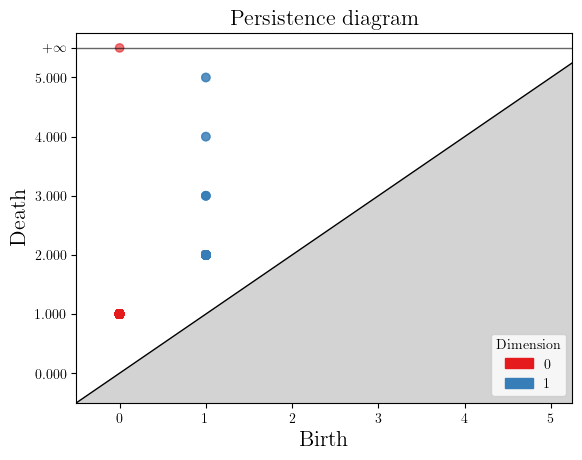

In [21]:
gd.plot_persistence_diagram(dgms)
plt.show()

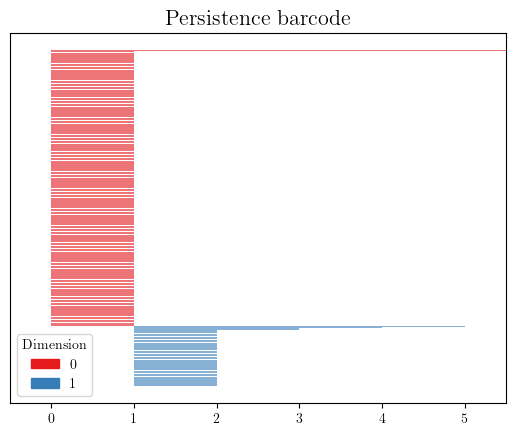

In [22]:
gd.plot_persistence_barcode(dgms)
plt.show()

In [23]:
print("Bars: ",dgms)

Bars:  [(1, (1.0, 5.0)), (1, (1.0, 5.0)), (1, (1.0, 4.0)), (1, (1.0, 4.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1

# For our experiments, we also need to generate synthetic cycle and figure eight graphs, with various directions and weights

## Unweighted Consistently Oriented Cycle

In [24]:
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)

In [25]:
Dcycle = distance_matrix(cycleG)

In [26]:
cyclecomplex = DowkerComplex(Dcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [27]:
dgmcycle = cyclecomplex.persistence()

In [28]:
dgmcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

## Weighted Consistently Oriented Cycle

In [29]:
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)

In [30]:
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)

In [31]:
nx.get_edge_attributes(weightedcycleG, 'weight')

{(0, 1): 3, (1, 2): 9, (2, 3): 3, (3, 4): 1, (4, 5): 8, (5, 0): 1}

In [32]:
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

In [33]:
Dcycleweighted

array([[ 0.,  3., 12., 15., 16., 24.],
       [22.,  0.,  9., 12., 13., 21.],
       [13., 16.,  0.,  3.,  4., 12.],
       [10., 13., 22.,  0.,  1.,  9.],
       [ 9., 12., 21., 24.,  0.,  8.],
       [ 1.,  4., 13., 16., 17.,  0.]])

In [34]:
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [35]:
dgmweightedcycle = weightedcyclecomplex.persistence()

In [36]:
dgmweightedcycle

[(1, (9.0, 13.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

## Not Consistently Oriented Cycle

In [37]:
notcycleG = nx.cycle_graph(6, create_using=nx.DiGraph)

notcycleG.remove_edge(3,4)
notcycleG.remove_edge(4,5)
notcycleG.remove_edge(5,0)
notcycleG.add_edge(4,3)
notcycleG.add_edge(5,4)
notcycleG.add_edge(0,5)


In [38]:
Dnotcycle = distance_matrix(notcycleG)

In [39]:
Dnotcycle

array([[   0.,    1.,    2.,    3.,    2.,    1.],
       [1000.,    0.,    1.,    2., 1000., 1000.],
       [1000., 1000.,    0.,    1., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000.],
       [1000., 1000., 1000.,    1.,    0., 1000.],
       [1000., 1000., 1000.,    2.,    1.,    0.]])

In [40]:
notcyclecomplex = DowkerComplex(Dnotcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [41]:
dgmnotcycle = notcyclecomplex.persistence()

In [42]:
dgmnotcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

## Wedges of graphs

In [43]:
# Inputs: G1 - a networkx graph
#        G2 - a networkx graph
# Outputs: G - a wedge sum of G1 and G2 where lowest node label of G2 is highest node label of G1 
def wedge_graphs(G1, G2):
    n1 = G1.number_of_nodes()
    n2 = G2.number_of_nodes()

    relabels = {i: i + n1 for i in range(n2-1)} # distinct labels for G2's nodes
    relabels[n2-1] = n1-1 # G2's first node is G1's last node (like a figure 8)
    G2 = nx.relabel_nodes(G2, relabels)
    G = nx.compose(G1, G2)
    return G

In [44]:
# Inputs: n1 - number of nodes in first cycle
#         n2 - number of nodes in second cycle
# Outputs: G - a wedge sum of two cycles, like a figure 8
def wedge_cycles(n1, n2):
    G1 = nx.cycle_graph(n1, create_using=nx.DiGraph)
    G2 = nx.cycle_graph(n2, create_using=nx.DiGraph)
    return wedge_graphs(G1, G2)

In [45]:
def figure_8_dgm(n1, n2, weighted = False):
    G = wedge_cycles(n1, n2)
    if weighted:
        weightedG = weight_graph(G, np.random.randint, 1, 10)
        D = distance_matrix(weightedG, 'weighted_shortest_path')
    else:
        D = distance_matrix(G, 'unweighted_shortest_path')
    complex = DowkerComplex(D).create_simplex_tree(filtration='Sublevel', max_dimension=2)
    dgms = complex.persistence()
    return dgms, G

In [46]:
dgms, fig8 = figure_8_dgm(5, 12, weighted=True)

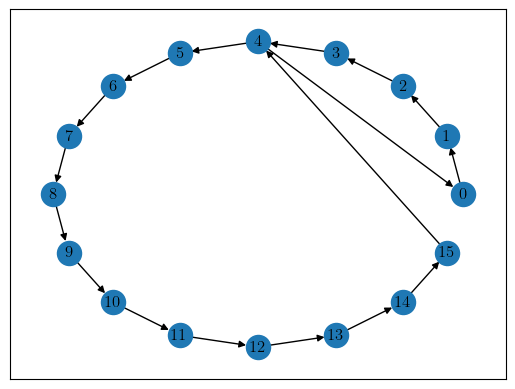

In [54]:
nx.draw_networkx(fig8, pos=nx.circular_layout(fig8))
# guarantee no crossings, but the proportions might be odd looking 

In [75]:
cycle5 = nx.cycle_graph(5, create_using = nx.DiGraph)
pos5 = nx.circular_layout(cycle5)
cycle12 = nx.cycle_graph(12, create_using = nx.DiGraph)
pos12 = nx.circular_layout(cycle12)

In [61]:
pos5

{0: array([1., 0.]),
 1: array([0.30901695, 0.95105657]),
 2: array([-0.80901706,  0.58778526]),
 3: array([-0.809017  , -0.58778532]),
 4: array([ 0.3090171 , -0.95105651])}

In [77]:
mirror_pos5 = {}
for k,v in pos5.items():
    flipped_x = v[0] +2*(1-v[0])
    mirror_pos5[k] = [flipped_x,v[1]]

In [84]:
mirror_pos5

{0: [1.0, 0.0],
 1: [1.690983047812672, 0.9510565683560541],
 2: [2.8090170564954597, 0.587785261505403],
 3: [2.809016996890813, -0.5877853211100496],
 4: [1.6909828988010556, -0.9510565087514076]}

In [62]:
pos12

{0: array([1.00000000e+00, 1.97028653e-08]),
 1: array([0.86602539, 0.50000001]),
 2: array([0.49999998, 0.86602545]),
 3: array([-2.36778241e-08,  1.00000000e+00]),
 4: array([-0.50000003,  0.86602539]),
 5: array([-0.86602535,  0.50000007]),
 6: array([-9.99999960e-01, -6.77199095e-08]),
 7: array([-0.86602541, -0.49999994]),
 8: array([-0.49999988, -0.86602541]),
 9: array([ 3.19584437e-08, -9.99999960e-01]),
 10: array([ 0.49999992, -0.86602541]),
 11: array([ 0.86602533, -0.50000015])}

In [66]:
diff = [1,0] - pos5[4]

In [64]:
pos12[0]

array([1.00000000e+00, 1.97028653e-08])

In [70]:
for k,v in pos5.items():
    pos5[k] = v + diff

In [71]:
pos5

{0: array([1.6909829 , 0.95105651]),
 1: array([0.99999985, 1.90211308]),
 2: array([-0.11803416,  1.53884177]),
 3: array([-0.1180341 ,  0.36327119]),
 4: array([1., 0.])}

In [85]:
pos = {}
for k,v in mirror_pos5.items():
    if k != 0:
        pos[k-1] = v
    if k == 0:
        pos[4] = v
for k,v in pos12.items():
    if k != 0:
        pos[k+4] = v

In [86]:
pos

{4: [1.0, 0.0],
 0: [1.690983047812672, 0.9510565683560541],
 1: [2.8090170564954597, 0.587785261505403],
 2: [2.809016996890813, -0.5877853211100496],
 3: [1.6909828988010556, -0.9510565087514076],
 5: array([0.86602539, 0.50000001]),
 6: array([0.49999998, 0.86602545]),
 7: array([-2.36778241e-08,  1.00000000e+00]),
 8: array([-0.50000003,  0.86602539]),
 9: array([-0.86602535,  0.50000007]),
 10: array([-9.99999960e-01, -6.77199095e-08]),
 11: array([-0.86602541, -0.49999994]),
 12: array([-0.49999988, -0.86602541]),
 13: array([ 3.19584437e-08, -9.99999960e-01]),
 14: array([ 0.49999992, -0.86602541]),
 15: array([ 0.86602533, -0.50000015])}

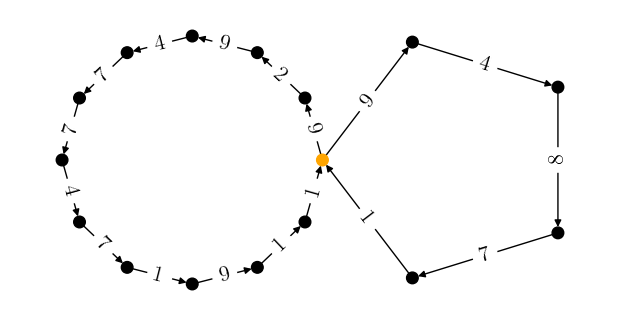

In [99]:
edge_labels = nx.get_edge_attributes(fig8, 'weight')
color = ['black']
color *= 16
color[4] = 'orange'

plt.figure(figsize = (6,3))
nx.draw(fig8, pos = pos, node_color = color, node_size = 70)
nx.draw_networkx_edge_labels(fig8, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black');

plt.savefig("wedge_sum1.pdf")

In [48]:
dgms

[(1, (9.0, 31.0)),
 (1, (9.0, 15.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

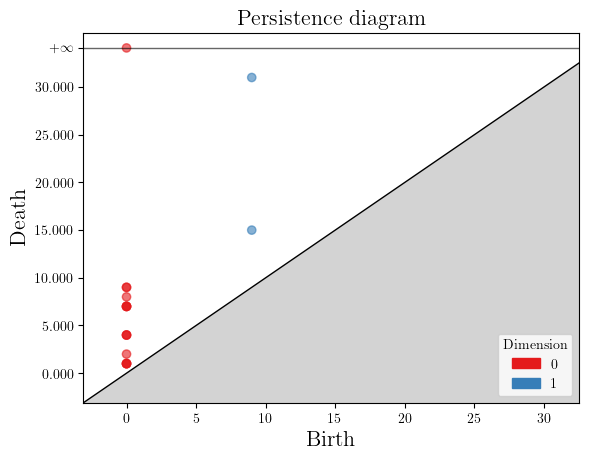

In [49]:
gd.plot_persistence_diagram(dgms)
plt.show()

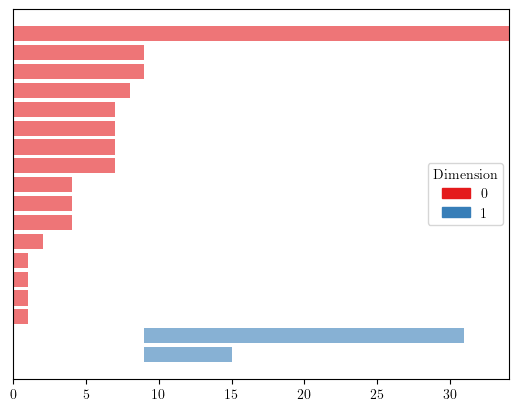

In [105]:

gd.plot_persistence_barcode(dgms)
plt.title('')
plt.gca().set_xlim(left=0)
plt.savefig("wedge_sum_1_barcode.pdf")

In [51]:
def wedge_barcode_differences(G1, G2, weighted = False):
    # claim that the dim 1 barcode of wedge is the union of the two barcodes

    G = wedge_graphs(G1, G2)
    graphs = [G1, G2, G]

    # get the dimension 1 persistence diagrams for each graph
    all_dgms = []
    for graph in graphs:
        if weighted:
            D = distance_matrix(graph, 'weighted_shortest_path')
        else:
            D = distance_matrix(graph, 'unweighted_shortest_path')
        complex = DowkerComplex(D).create_simplex_tree(filtration='Sublevel', max_dimension=2)
        dgms = complex.persistence()
        dgm_dim1 = [dgm[1] for dgm in dgms if dgm[0] == 1]
        all_dgms.append(dgm_dim1)

    dgm_union = set(all_dgms[0] + all_dgms[1]) # union of the two individual barcodes
    wedged_dgm = set(all_dgms[2]) # barcode of the wedge sum
    if dgm_union != wedged_dgm:
        print("Dimension 1 barcode of wedge sum does NOT match the union of the individual barcodes.")
    else:
        print("Dimension 1 barcode of wedge sum DOES match the union of the individual barcodes.")
        
    print("Diagram of G1:", all_dgms[0])
    print("Diagram of G2:", all_dgms[1])
    print("Diagram of wedge sum:", all_dgms[2])
    return all_dgms

    


In [52]:
n1 = 5
n2 = 12
G1 = nx.cycle_graph(n1, create_using=nx.DiGraph)
G2 = nx.cycle_graph(n2, create_using=nx.DiGraph)

dgms_dim1  = wedge_barcode_differences(G1, G2, weighted=True)



Dimension 1 barcode of wedge sum DOES match the union of the individual barcodes.
Diagram of G1: [(1.0, 3.0)]
Diagram of G2: [(1.0, 6.0)]
Diagram of wedge sum: [(1.0, 6.0), (1.0, 3.0)]


In [53]:
weightedG1 = weight_graph(G1, np.random.randint, 1, 10)
weightedG2 = weight_graph(G2, np.random.randint, 1, 10)
dgms_dim1_weighted = wedge_barcode_differences(weightedG1, weightedG2, weighted=True)

Dimension 1 barcode of wedge sum DOES match the union of the individual barcodes.
Diagram of G1: [(8.0, 12.0)]
Diagram of G2: [(9.0, 37.0)]
Diagram of wedge sum: [(9.0, 37.0), (8.0, 12.0)]
